In [1]:
# generate future y values using past x values AND greater offset y values 

In [1]:
import pandas as pd
import numpy as np
import os
import shutil
import openpyxl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as plt
import re

from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV



from sklearn.preprocessing import MinMaxScaler


from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline

from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

from sklearn.metrics import mean_squared_error, mean_absolute_error



from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
from scikeras.wrappers import KerasRegressor


import pickle


In [2]:

def convert_to_dataframe(x):
    return pd.DataFrame(x)


In [3]:
def create_sequences(features, target, seq_length, y_offset):
    X, y = [], []
    for i in range(seq_length, len(features)):
        # Current features sequence
        current_features = features[i-seq_length:i]
        
        # Offset previous y values sequence
        if i - seq_length - y_offset >= 0:
            offset_prev_y = target[i-seq_length-y_offset:i-y_offset]
        else:
            # If the offset is larger than the available data, fill with zeros or appropriate value
            offset_prev_y = np.zeros((seq_length, 1))
        
        # Combine current features with offset previous y values
        combined = np.hstack((current_features, offset_prev_y))
        
        X.append(combined)
        y.append(target[i])
    
    return np.array(X), np.array(y)



In [4]:
def predict_future(model, data, seq_length, future_steps):
    future_predictions = []
    current_sequence = data[-seq_length:].reshape(1, seq_length, data.shape[1])
    
    return(current_sequence)

In [10]:
df = pd.read_csv('xover_data_copy.csv')
df_copy = df.copy()
df_copy = df_copy.drop('Unnamed: 0',axis=1) 
# df_copy


# to_drop = ['temp_anode_inlet_set', 
#            'temp_cathode_inlet_set', 
#            'pressure_anode_set',
#            'pressure_cathode_set', 
#            'flow_anode_di_water_supply_set', 
#            'flow_cathode_di_water_supply_set', 
#           'flow_cathode_di_water_supply', 
#            'signal_in_o2_in_h2_sensor']

# df_copy = df_copy.drop(to_drop, axis=1)
df_copy


df_copy['seconds'] = (df_copy['time_running_total']/1000).astype(int)
df_copy['minutes'] = (df_copy['seconds']/60).astype(int)

# df_copy['hours'] = (df_copy['minutes']/60).astype(int)
# df_copy['days'] = (df_copy['hours']/24).astype(int)
# df_copy['weeks'] = (df_copy['days']/7).astype(int)
df_copy = df_copy.drop('time_running_total',axis=1)

# df_copy = df_copy.tail(150000)
df_copy

,current,voltage,beck.b1.m11.ch3,seconds,minutes
0,0.01384,-0.01138,10.000000,0,0
1,0.01384,-0.01138,10.000000,0,0
2,0.01330,-0.01233,10.000000,30,0
3,0.01330,-0.01233,10.000000,30,0
4,0.01277,-0.01233,10.000000,60,1
...,...,...,...,...,...
16399,0.01117,-0.00569,1.396832,266220,4437
16400,0.01064,-0.00474,1.396832,266250,4437
16401,0.01010,-0.00474,1.396832,266280,4438
16402,0.01117,-0.00474,1.396832,266310,4438


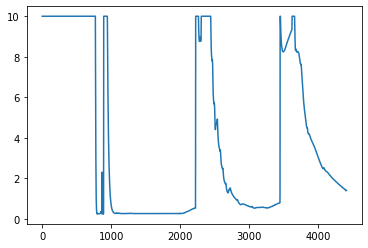

,voltage,current,beck.b1.m11.ch3
minutes,,,
2024-05-16 00:00:00,-0.011855,0.013570,10.000000
2024-05-16 00:01:00,-0.012330,0.012505,10.000000
2024-05-16 00:02:00,-0.011855,0.012240,10.000000
2024-05-16 00:03:00,-0.010905,0.011970,10.000000
2024-05-16 00:04:00,-0.010430,0.012240,10.000000
...,...,...,...
2024-05-19 01:55:00,-0.006165,0.011170,1.394391
2024-05-19 01:56:00,-0.005690,0.010370,1.394391
2024-05-19 01:57:00,-0.005215,0.010905,1.396832


In [12]:
import matplotlib.pyplot as plt

time_period = 'minutes'

df_time = df_copy.groupby(time_period).mean().reset_index()

downsampled_df = df_time.tail(24000).reset_index()

downsampled_df = downsampled_df[['minutes','voltage','current','beck.b1.m11.ch3']]

downsampled_df[time_period] = pd.to_datetime('2024-05-16 00:00:00') + pd.to_timedelta(downsampled_df[time_period], unit='m')



plt.plot(downsampled_df['beck.b1.m11.ch3'])

plt.show()

downsampled_df = downsampled_df.set_index('minutes')
downsampled_df

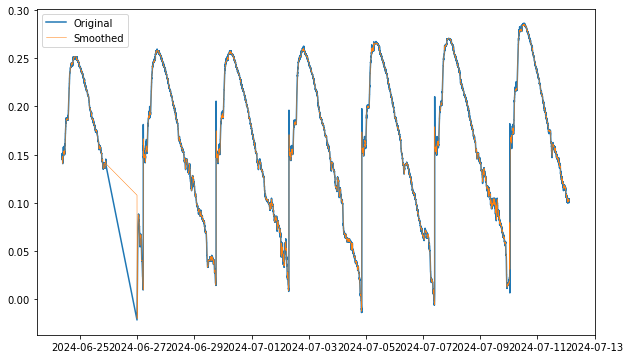

In [95]:


# feture engineering 

# adding trend to provide the model with increasing trend data

trend = (np.arange(len(downsampled_df))).tolist()
trend


downsampled_df['trend'] = trend
downsampled_df



# smoothing the data using a moving average

def moving_average(data, window=5):
    return data.rolling(window=window).mean()



downsampled_df['smoothed_value'] = moving_average(downsampled_df['signal_in_h2_in_o2_sensor'], window=5)

downsampled_df = downsampled_df.dropna()
downsampled_df


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(downsampled_df['signal_in_h2_in_o2_sensor'], label='Original')
plt.plot(downsampled_df['smoothed_value'], label='Smoothed', linewidth=0.5)
plt.legend()
plt.show()

In [96]:
# pipeline


pipeline = Pipeline([
    ('scaler', MinMaxScaler()),

])

# Fit and transform the data


features = downsampled_df.drop(columns= ['signal_in_h2_in_o2_sensor'])
target = downsampled_df['signal_in_h2_in_o2_sensor']


features_trans = pipeline.fit_transform(features)
target_trans = pipeline.fit_transform(pd.DataFrame(target))



seq_length = 3  # Using  to predict the next minute
y_offset = 3500
X, y = create_sequences(features_trans, target_trans, seq_length, y_offset)

In [98]:
ts = 0.5

train_size = int(len(X) * ts)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]



In [99]:
# Tuning of Hyperparameters 

In [100]:
import keras.backend as K
from keras.callbacks import EarlyStopping
import keras_tuner as kt
from tensorflow.keras.layers import Dropout
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

In [101]:
def create_model():
    model = Sequential()
    
    model.add(LSTM(120,
                   return_sequences = True,
                   input_shape = (X_train.shape[1], X_train.shape[2])))


    model.add(Dropout(0.4))


    model.add(LSTM(140, return_sequences = False))


    model.add(Dropout(0.1))


    model.add(Dense(1))         
                           
    
    
    model.compile(optimizer='adam', loss = 'mean_squared_error', metrics = ['mse'])
    return model

In [102]:
model = create_model()

In [103]:
model.fit(x=X_train,
    y=y_train,
    epochs=20,
    batch_size=128,
    validation_data=(X_test, y_test),)

Epoch 1/20
94/94 [==============================] - 8s 35ms/step - loss: 0.0365 - mse: 0.0365 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 2/20
94/94 [==============================] - 2s 23ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 7.2151e-04 - val_mse: 7.2151e-04
Epoch 3/20
94/94 [==============================] - 3s 29ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 5.1780e-04 - val_mse: 5.1780e-04
Epoch 4/20
94/94 [==============================] - 2s 26ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 3.0615e-04 - val_mse: 3.0615e-04
Epoch 5/20
94/94 [==============================] - 2s 23ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 2.9555e-04 - val_mse: 2.9555e-04
Epoch 6/20
94/94 [==============================] - 2s 23ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 4.6414e-04 - val_mse: 4.6414e-04
Epoch 7/20
94/94 [==============================] - 2s 23ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 2.8717e-04 - val_mse: 2.8717e-04
Epoch 8/20
94/94 [=================

In [105]:
predictions = model.predict(X_test)


375/375 [==============================] - 1s 3ms/step


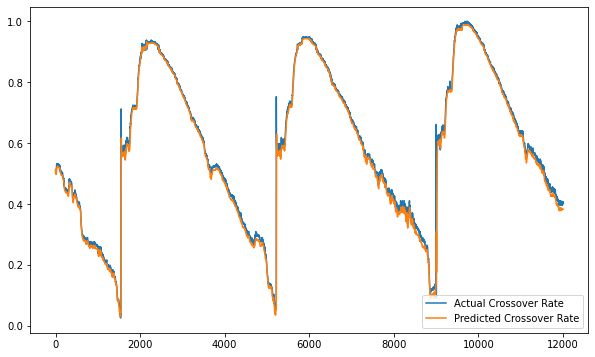

In [106]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Crossover Rate')
plt.plot(predictions, label='Predicted Crossover Rate')
plt.legend()
plt.show()

In [112]:



train_size = int(len(X) * ts)
X_train_downsampled_df, X_test_downsampled_df = downsampled_df[:train_size], downsampled_df[train_size:]




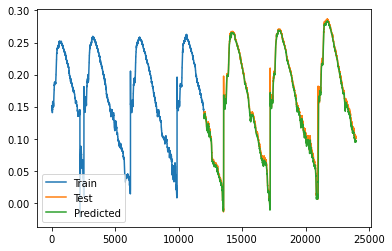

In [113]:
# Plot actual vs predicted value

plt.plot(range(len(X_train_downsampled_df)), X_train_downsampled_df['signal_in_h2_in_o2_sensor'].tolist(), label='Train')
plt.plot(range(len(X_train_downsampled_df), len(downsampled_df)-3), pipeline.named_steps['scaler'].inverse_transform(y_test), label='Test')
plt.plot(range(len(X_train), len(downsampled_df)-3), pipeline.named_steps['scaler'].inverse_transform(predictions), label='Predicted')
plt.legend()
plt.show()

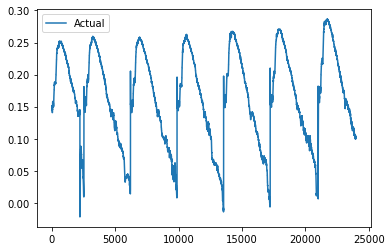

In [115]:
# Original Dataset

plt.plot(range(len(downsampled_df)), downsampled_df['signal_in_h2_in_o2_sensor'].tolist(), label='Actual')
plt.legend()
plt.show()